# <span style="color:darkblue"> Laboratorio di Simulazione Numerica </span>
#### <span style="color:darkred">  Riccardo Beccaria - Luglio 2021</span>

# <span style="color:green"> Esercitazione 7<span>

### Esercizio 07.1

Use the Monte Carlo NVT code we have provided to print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along equilibrated Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

Il codice Monte Carlo NVT fornito, simula lo stesso sistema delle 108 particelle di Argon già presentato nella quarta esercitazione. Come nella quarta esercitazione, sono state utilizzate le unità di misura Lennard-Jones per la simulazione. Nella esercitazione 4, questo insieme di particelle di Argon veniva simulato in un <span style="color:red">insieme microcanonico NVE</span>: dove a rimanere costanti sono N numero di particelle, il volume V e l'energia E. Questo era possibile grazie all'utilizzo dell'Algoritmo di Verlet, che anche ad un elevato numero di step dall'inizio della simulazione mantiene il sistema ad energia costante.

In questa esercitazione invece, il sistema viene simulato in un <span style="color:red">insieme canonico NVT</span> dove oltre al numero di particelle N e il volume V, è la temperaura T a rimanere costante. Infatti, in questa esercitazione, l'evoluzione di questo centinaio di particelle viene eseguito non più con una dinamica molecolare deterministica, ma attraverso un campionamento Monte Carlo grazie all'utilizzo dell'Algoritmo di Metropolis. Come probabilità tentativa $T(x|y)$ è stata utilizzata una probabilità uniforme estraendo un passo $r \in [-\sigma, \sigma]$ con cui si vuole spostare la singola particella. Infatti, ogni volta che viene richiamata la funzione `Move()` viene compiuto un ciclo su tutte le 108 particelle del sistema. Per ogni particella si tenta di muovere ciascuna delle tre coordinate di un passo $r$, e si accetta questa nuova configurazione con probabilità $A(x|y)=min(1, e^{-\beta(E_{new}-E_{old})})$. Infatti in un ensamble canonico le conformazioni sono distribuite secondo il peso di Boltzmann.
Ovviamente è stato necessario scegliere valori di $\sigma$ così da garantire un'accettazione del Metropolis del 50%, ovvero: $\sigma_{solid}=0.11$, $\sigma_{solid}=0.2$, $\sigma_{gas}=20$. Non mi stupisce il fatto che che la fase solida sia quella con $\sigma$ minore e che invece la fase gassosa sia quella con $\sigma$ minore. Infatti il gas, avendo particelle che subiscono minore attrazione reciproca (domina la parte cinetica data la alta temperatura), occuperà un maggiore volume. pertanto per avere un buon campionamento sarà necessario aumentare il passo con cui provo a generare nuove configurazioni nell'Algoritmo di Metropolis. I valori di $\sigma$ vengono passati al codice attraverso i file di input <font face="Courier">input.solid</font>, <font face="Courier">input.liquid</font> e <font face="Courier">input.gas</font>.





Il primo punto dell'esercizio richiede uno script in python per studiare le funzioni di autocorrelazioni delle quantità $\frac{U}{N}$ e $P$. Dopo quindi una prima fase di equilibrazione ho effettuato la vera e propria simulazioni. Per studiare le funzioni di correlazione, ho dovuto stampare ad ogni step della simulazione i valori di energia e pressione in un apposito file di output. In particolare, ad ogni step, dopo aver eseguito un passo conl Metropolis utilizzando `Move()` viene richiamata la funzione `Measure()` che per l'appunto misura le quantità di interesse e ad ogni passo della simulazione stampa i valori di energia e pressione dei file: <font face="Courier">istantaneus.epot</font> e <font face="Courier">istantaneus.pres</font>.

La <span style="color:red">funzione di autocorrelazione AC</span> di una certa ossrvabile viene calcolata come:

$$ AC(t') = \frac{\left\langle m(t)m(t+t') \right\rangle - \left\langle m(t) \right\rangle\left\langle m(t+t') \right\rangle}{\sigma^2_m}$$

Questa funzione esprime quanto sono correlati due valori di questa osservabile che distano un tempo $t'$ l'uno dall'altro. Ho riportato nei grafici sottostanti le funzioni di autocorrelazioni osservate.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
%config InlineBackend.figure_format = 'retina'

In [2]:
(Epot_solid) = np.loadtxt('./MonteCarlo_NVT/solid_phase/istantaneus.epot', unpack=True, usecols=(0))
(Pres_solid) = np.loadtxt('./MonteCarlo_NVT/solid_phase/istantaneus.pres', unpack=True, usecols=(0))

(Epot_liquid) = np.loadtxt('./MonteCarlo_NVT/liquid_phase/istantaneus.epot', unpack=True, usecols=(0))
(Pres_liquid) = np.loadtxt('./MonteCarlo_NVT/liquid_phase/istantaneus.pres', unpack=True, usecols=(0))

(Epot_gas) = np.loadtxt('./MonteCarlo_NVT/gas_phase/istantaneus.epot', unpack=True, usecols=(0))
(Pres_gas) = np.loadtxt('./MonteCarlo_NVT/gas_phase/istantaneus.pres', unpack=True, usecols=(0))

In [3]:
def ACF(x, tn):
    ac=np.zeros(tn)
    tmax=x.size
    for t in range(tn):
        ac[t]=(np.sum(x[0:tmax-t]*x[t:])/(tmax-t)-(np.sum(x[0:tmax-t])*np.sum(x[t:]))/(tmax-t)**2)/(np.sum(x*x)/tmax-(np.sum(x)/tmax)**2)
    return ac

def block_err (x,L):
    nblock =(int)(x.size/L)
    block_ave= np.zeros(nblock)
    for iblock in range (nblock):
        block_ave[iblock] = np.sum(x[iblock*L:(iblock+1)*L])/L
    return np.sqrt((np.sum(block_ave*block_ave)/nblock -(np.sum(block_ave)/nblock)**2)/nblock)

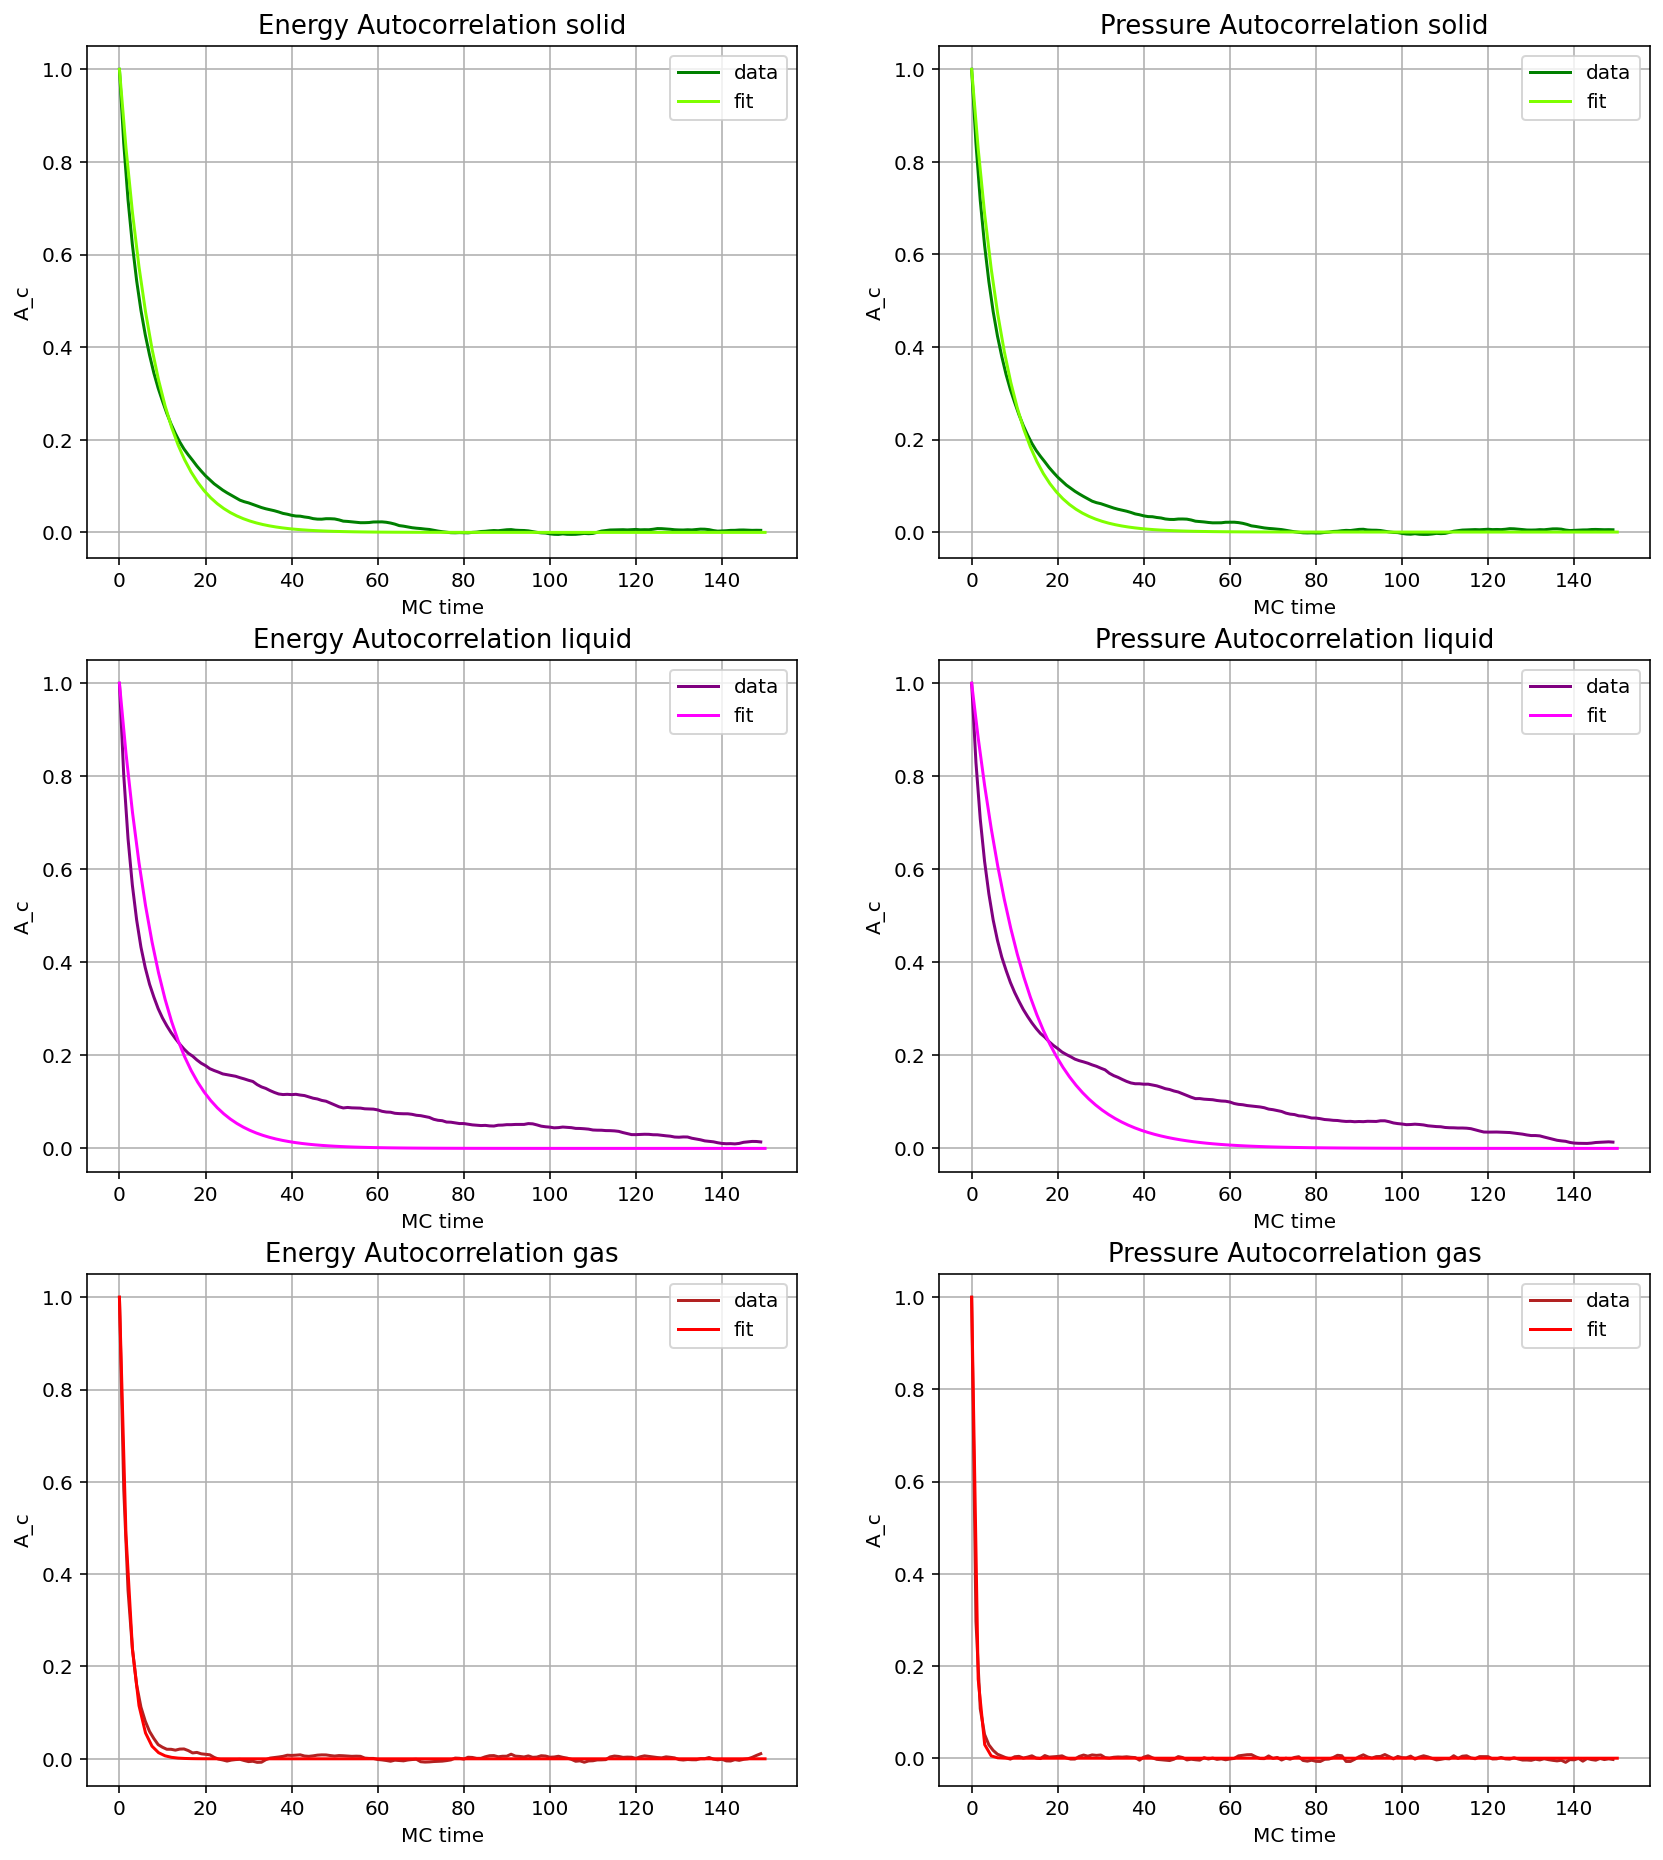

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(14,16))
x = np.arange(150)
maxlag=150

# Solid energy
axs[0,0].set_title("Energy Autocorrelation solid", fontsize=13)
axs[0,0].plot(ACF(Epot_solid,150), color='green', label='data')
par_u_s, corr_u_s = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Epot_solid,150), p0=1) #fit autocorr
x_pl = np.linspace(0,maxlag,100)
axs[0][0].plot(x_pl, np.exp(-par_u_s*x_pl), label='fit', color='chartreuse')

# Solid Pressure
axs[0,1].set_title("Pressure Autocorrelation solid", fontsize=13)
axs[0,1].plot(ACF(Pres_solid,150), color='green', label='data')
par_p_s, corr_p_s = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Pres_solid,150), p0=1) #fit autocorr
axs[0][1].plot(x_pl, np.exp(-par_p_s*x_pl), label='fit', color='chartreuse')

# Liquid energy
axs[1,0].set_title("Energy Autocorrelation liquid", fontsize=13)
axs[1,0].plot(ACF(Epot_liquid,150), color='purple', label='data')
par_u_l, corr_u_l = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Epot_liquid,150), p0=1) #fit autocorr
axs[1][0].plot(x_pl, np.exp(-par_u_l*x_pl), label='fit', color='fuchsia')

# Liquid Pressure
axs[1,1].set_title("Pressure Autocorrelation liquid", fontsize=13)
axs[1,1].plot(ACF(Pres_liquid,150), color='purple', label='data')
par_p_l, corr_p_l = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Pres_liquid,150), p0=1) #fit autocorr
axs[1][1].plot(x_pl, np.exp(-par_p_l*x_pl), label='fit', color='fuchsia')

# gas energy
axs[2,0].set_title("Energy Autocorrelation gas", fontsize=13)
axs[2,0].plot(ACF(Epot_gas,150), color='firebrick', label='data')
par_u_g, corr_u_g = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Epot_gas,150), p0=1) #fit autocorr
axs[2][0].plot(x_pl, np.exp(-par_u_g*x_pl), label='fit', color='red')

# gas Pressure
axs[2,1].set_title("Pressure Autocorrelation gas", fontsize=13)
axs[2,1].plot(ACF(Pres_gas,150), color='firebrick', label='data')
par_p_g, corr_p_g = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag),  ACF(Pres_gas,150), p0=1) #fit autocorr
axs[2][1].plot(x_pl, np.exp(-par_p_g*x_pl), label='fit', color='red')


for ax in axs.flat:
    ax.grid()
    ax.set_xlabel('MC time', fontsize=10)
    ax.set_ylabel('A_c', fontsize=10)
    ax.legend()
    

Quello che si può osservare è che anche nel caso della fase liquida, che è quella con funzione di correlazione che si smorza in tempi maggiori, dopo 100 passi Monte Carlo non si ha più correlazione tra le diverse misure. Evidentemente la fase gassosa è la fase con minore correlazione, proprio per il fatto che l'alta temperatura e il grande passo con l'algoritmo Metropolis, fanno avere al sistema in fase gassosa poca memoria. Ho fittato le funzioni di correlazioni con una funzione esponenziale riportata negli stessi grafici.
Osservare la funzione di autocorrelazione smorzarsi dopo 100 passi Monte Carlo è un primo suggerimento dell'ordine di grandezza che possiamo assumere per i blocchi nella fase di analisi di Data Blocking.

Per scegliere in maniera più rigorosa la lunghezza dei blocchi nella simulazione, ho fatto uno script python per studiare come varierebbero gli errori su queste due proprietà in funzione della lunghezza che avrebbe ciascun blocco. Infatti la simulazione è computazionalmente abbastanza onerosa. Pertanto non è intelligente prendere i blocchi con grandezza molto elevata. Per questa ragione si studia come varierebbero gli errori in funzione dei blocchi.

In [5]:
L=[10,25,50,100,200,500,1000,1250,2000,2500,3125,5000]

err_u_solid = np.zeros(len(L))
err_p_solid = np.zeros(len(L))
err_u_liquid = np.zeros(len(L))
err_p_liquid = np.zeros(len(L))
err_u_gas = np.zeros(len(L))
err_p_gas = np.zeros(len(L))

for i in range(len(L)):
    err_u_solid[i] = block_err(Epot_solid,L[i])
    err_p_solid[i] = block_err(Pres_solid,L[i])
    err_u_liquid[i] = block_err(Epot_liquid,L[i])
    err_p_liquid[i] = block_err(Pres_liquid,L[i])
    err_u_gas[i] = block_err(Epot_gas,L[i])
    err_p_gas[i] = block_err(Pres_gas,L[i])

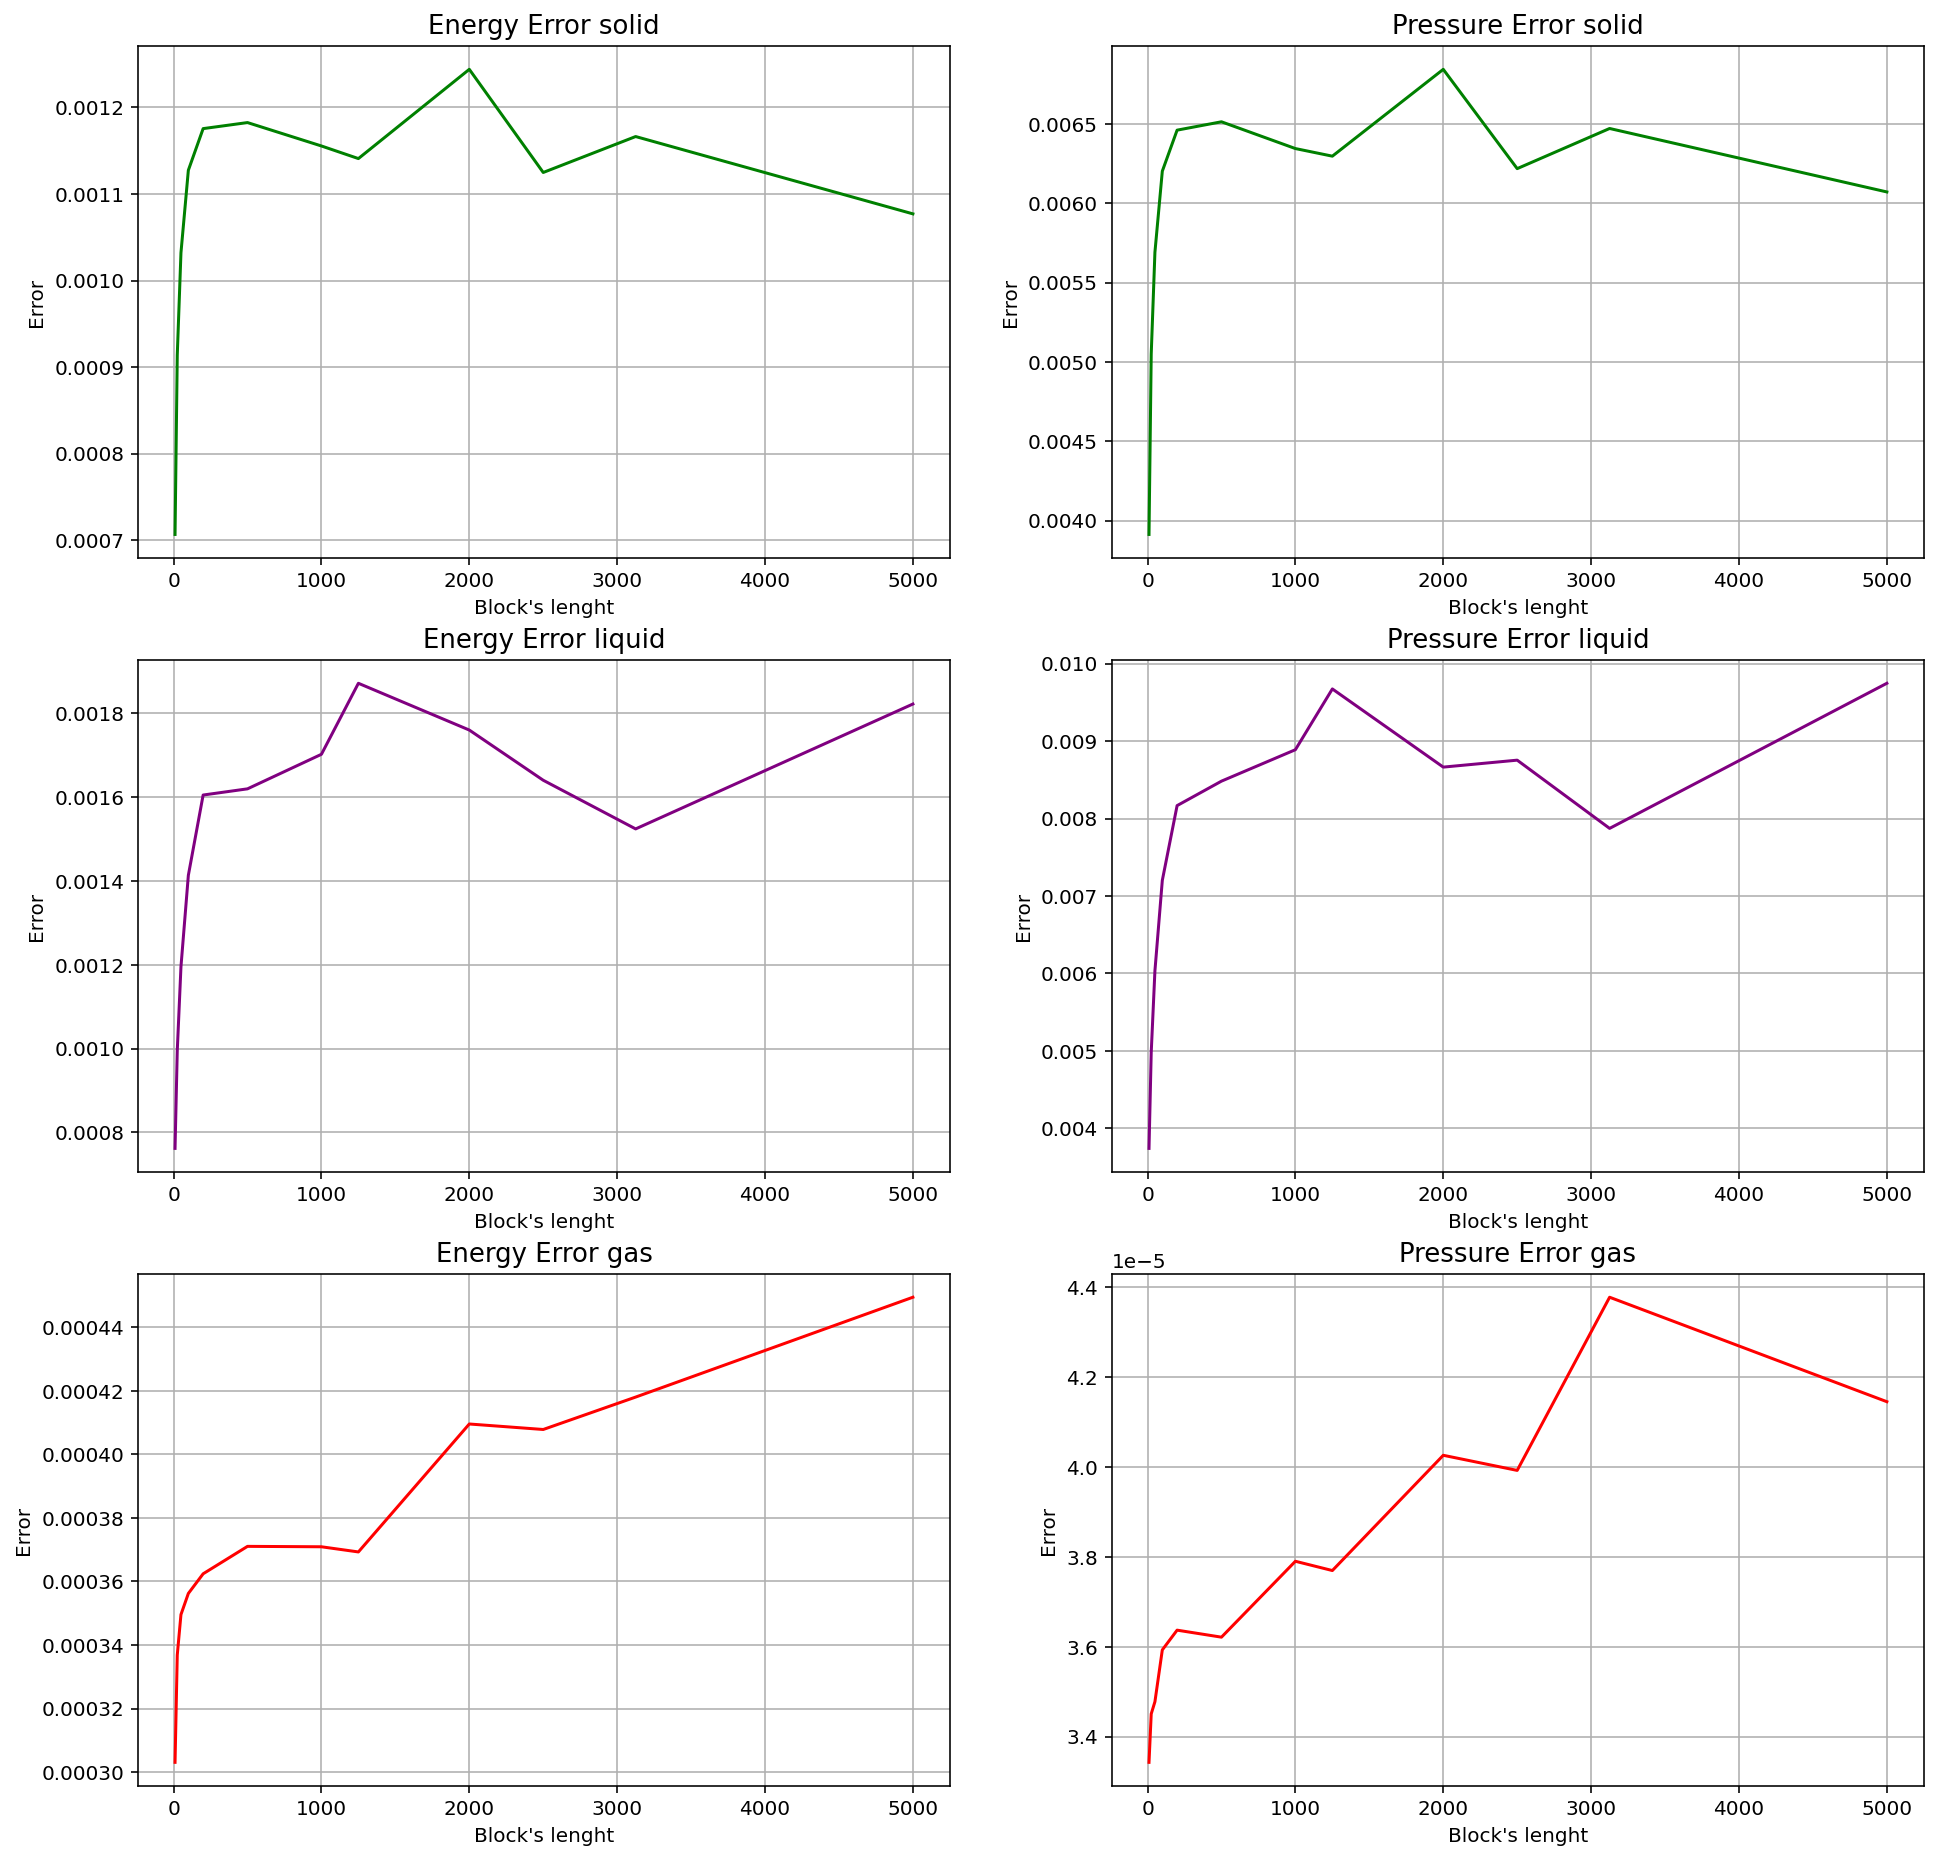

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(16,16))


# Solid energy
axs[0,0].set_title("Energy Error solid", fontsize=13)
axs[0,0].plot(L, err_u_solid, color='green')

# Solid energy
axs[0,1].set_title("Pressure Error solid", fontsize=13)
axs[0,1].plot(L, err_p_solid, color='green')

# Liquid energy
axs[1,0].set_title("Energy Error liquid", fontsize=13)
axs[1,0].plot(L, err_u_liquid, color='purple')

# Liquid energy
axs[1,1].set_title("Pressure Error liquid", fontsize=13)
axs[1,1].plot(L, err_p_liquid, color='purple')

# Gas energy
axs[2,0].set_title("Energy Error gas", fontsize=13)
axs[2,0].plot(L, err_u_gas, color='red')

# Gas energy
axs[2,1].set_title("Pressure Error gas", fontsize=13)
axs[2,1].plot(L, err_p_gas, color='red')


for ax in axs.flat:
    ax.grid()
    ax.set_xlabel('Block\'s lenght', fontsize=10)
    ax.set_ylabel('Error', fontsize=10)

Quello che generalmente si può osservare è che gli errori salutarano più o meno in corrispondenza di una lunghezza $L=1000$. Quindi anche se scegliessi una lunghezza dei blocchi maggiore di mille, non avrei un miglioramento sull'incertezza delle mie misure. Per quetsa ragione ho deciso che nel corso di questa simulazione ho studiato le osservabili col il metodo di Data Blocking utilizzando 100 blocchi ciascuno di lunghezza 1000.

### Esercizio 07.2 e Esercizio 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the Monte Carlo NVT code we have provided: average value of $g(r)$ in each block (with output in the file: output.gofr.0), final average value of $g(r)$ with statistical uncertainties (with output in the file: output.gave.0).
Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code.




È stata implementata nel codice la misura della <span style="color:red">funzione di distribuzione radiale a coppie $g(r)$</span>.  Questa funzione fornisce la probabilità di trovare una coppia di atomi a una distanza $r$, rispetto la probabilità di trovare la stessa coppia di atomi a quella distanza in una distribuzione completamente casuale: quindi in una distribuzione di un gas ideale. Quindi per definizione la distribuzione radiale a coppie viene definita come il rapporto tra la densità di probabilità di trovare due particelle a una distanza $r$ nel sistema, e la stessa densità in un gas ideale. Chiaramente questa distribuzione di proabbilità è ottenuta marginalizzando al distribuzione di probabilità di Boltzmann del sistema sugli altri gradi di libertà non considerati: $g(r)= \frac{\rho^{(2)}(r_1,r_2)}{\prod_{i=1}^2\rho^{(1)}(r_i)}$. Da notare che a denominatore la densità di probabilità si fattorizza proprio per il fatto di avere un gas ideale: particelle indipendenti.

Operativamente, la misura di $g(r)$ è molto facile. Si divide l'intervallo $[0, \frac{L}{2}]$ in 100 intervalli più piccoli di uguale dimnesione. Ad ogni step della simulazione si cicla su tutte le particelle del sistema. Per ogni coppia di particelle si misura la distanza $r^*$ e se $r_i<r^*<r_{i+1}$ si riempie di 2 quel bin dell'istogramma costuito: lo riempio di due e non di uno perchè è una copia di particelle, e non una particella sola. Al termine del riempimento si normalizza l'istogramma con la quantità $\rho N_{int} \Delta V(r)$ dove $\Delta V(r) = \frac{4\pi}{3} \left[ (r+dr)^3 - r^3\right]$. Dopo aver testato questa implementazione nell'esercitazione 7, ho implementato il calcolo della $g(r)$ anche nell'inisieme microcanonico NVE dell'esercitazione 4.

### Esercizio 07.4

By means of your upgraded MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in SI units ...  and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

Una volta implementato l'algoritmo per il calcolo della $g(r)$ ho iniziato la mia simulazione del sistema di Argon in un ensamble canonico, nelle tre diverse fasi solida, liquida e gassosa. Ad ogni fase, dopo aver equilibrato opportunamente il sistema, vengono compiuti $10^5$ campionamenti Metropolis suddivisi in 100 blocchi, per i motivi già presentati nel primo punto dell'esercitazione. Ho riportato i grafici nel sistema internazionale SI, analizzandoli attraverso la tecnica del Data Blocking. Si può infatti osservare una convergenza di energia e pressione a un certo valore per tutte e tre le fasi, e valori sempre più minori dell'errore con l'aumentare del numero di blocchi

<span style="color:red">N.B.</span> In questo codice, ogni volta che viene richiamata la funzione `Measure()` si calcolano il potenziale e la pressione delle particelle che hanno una distanza inferiore alla distanza di cutoff $r_c$. Nel codice sono implementate le correzione *tail correlations* per tenere conto degli effetti a grandi distanze. In particolare, queste si ottengono assumendo una $g(r) \simeq 1$ come si osserva a grandi distanze. In particolare:
1. $\langle V \rangle_{tail}=2\pi \rho N \int_{r_c}^{\infty}dr r^2V(r)g(r)$ e con $g(r) \simeq 1$ si ottiene: $\langle V \rangle_{tail}=\frac{8 \pi \rho}{9 r_c^9} - \frac{8 \pi \rho}{3 r_c^3}$
2. Allo stesso modo con la pressione si ottiene: $\langle p \rangle_{tail}= \frac{32 \pi \rho}{9 r_c^9} - \frac{16 \pi \rho}{3 r_c^3}$


È molto interessante l'andamento della funzione di distribuzione radiale a coppie $g(r)$. In particolare:
- Innanzitutto si osservano valori nulli al di sotto del $\sigma$. E questo non mi stupisce! Infatti a differenza dei gas ideali, questo sistema simulato (in tutte e tre le fasi), presenta una parte di Core. Se si pensa al potenzial Lennard-Jones non si possono avvicinare due particelle a una distanza a piacere. Questo fenomeno di core invece non si presenta nel gas idea. Per questa ragione la $g(r)$ va a zero: ho un numeratore che va a zero, mentre il denonimatore rimane diverso da zero
- Nella zona più centrale invece, poco sopra il valore di $\sigma$ si possono osservare dei comportamenti ondulatori della $g(r)$. Laddove la $g(r)>1$ significa che ho più probabilità di trovare due atomi a quella distanza $r$ nel mio sistema che in un gas ideale: viceversa se $g(r)<1$. Questo comportamento ondulatorio mostra una distribuzione a shell sferiche del sistema.
- Da ultimo non mi sorprende che la $g(r)$ tenda ad 1 per alti valori di $r$. Sia nell'insieme canonico, che nel microcanonico, nel limite termodinamico (alte temperature), il sistema tende ad un gas ideale, come noto dalla meccanica statistica


I risultati della $g(r)$ ottenuti nel canonico e nel microcanonico, sono coerenti tra di loro.

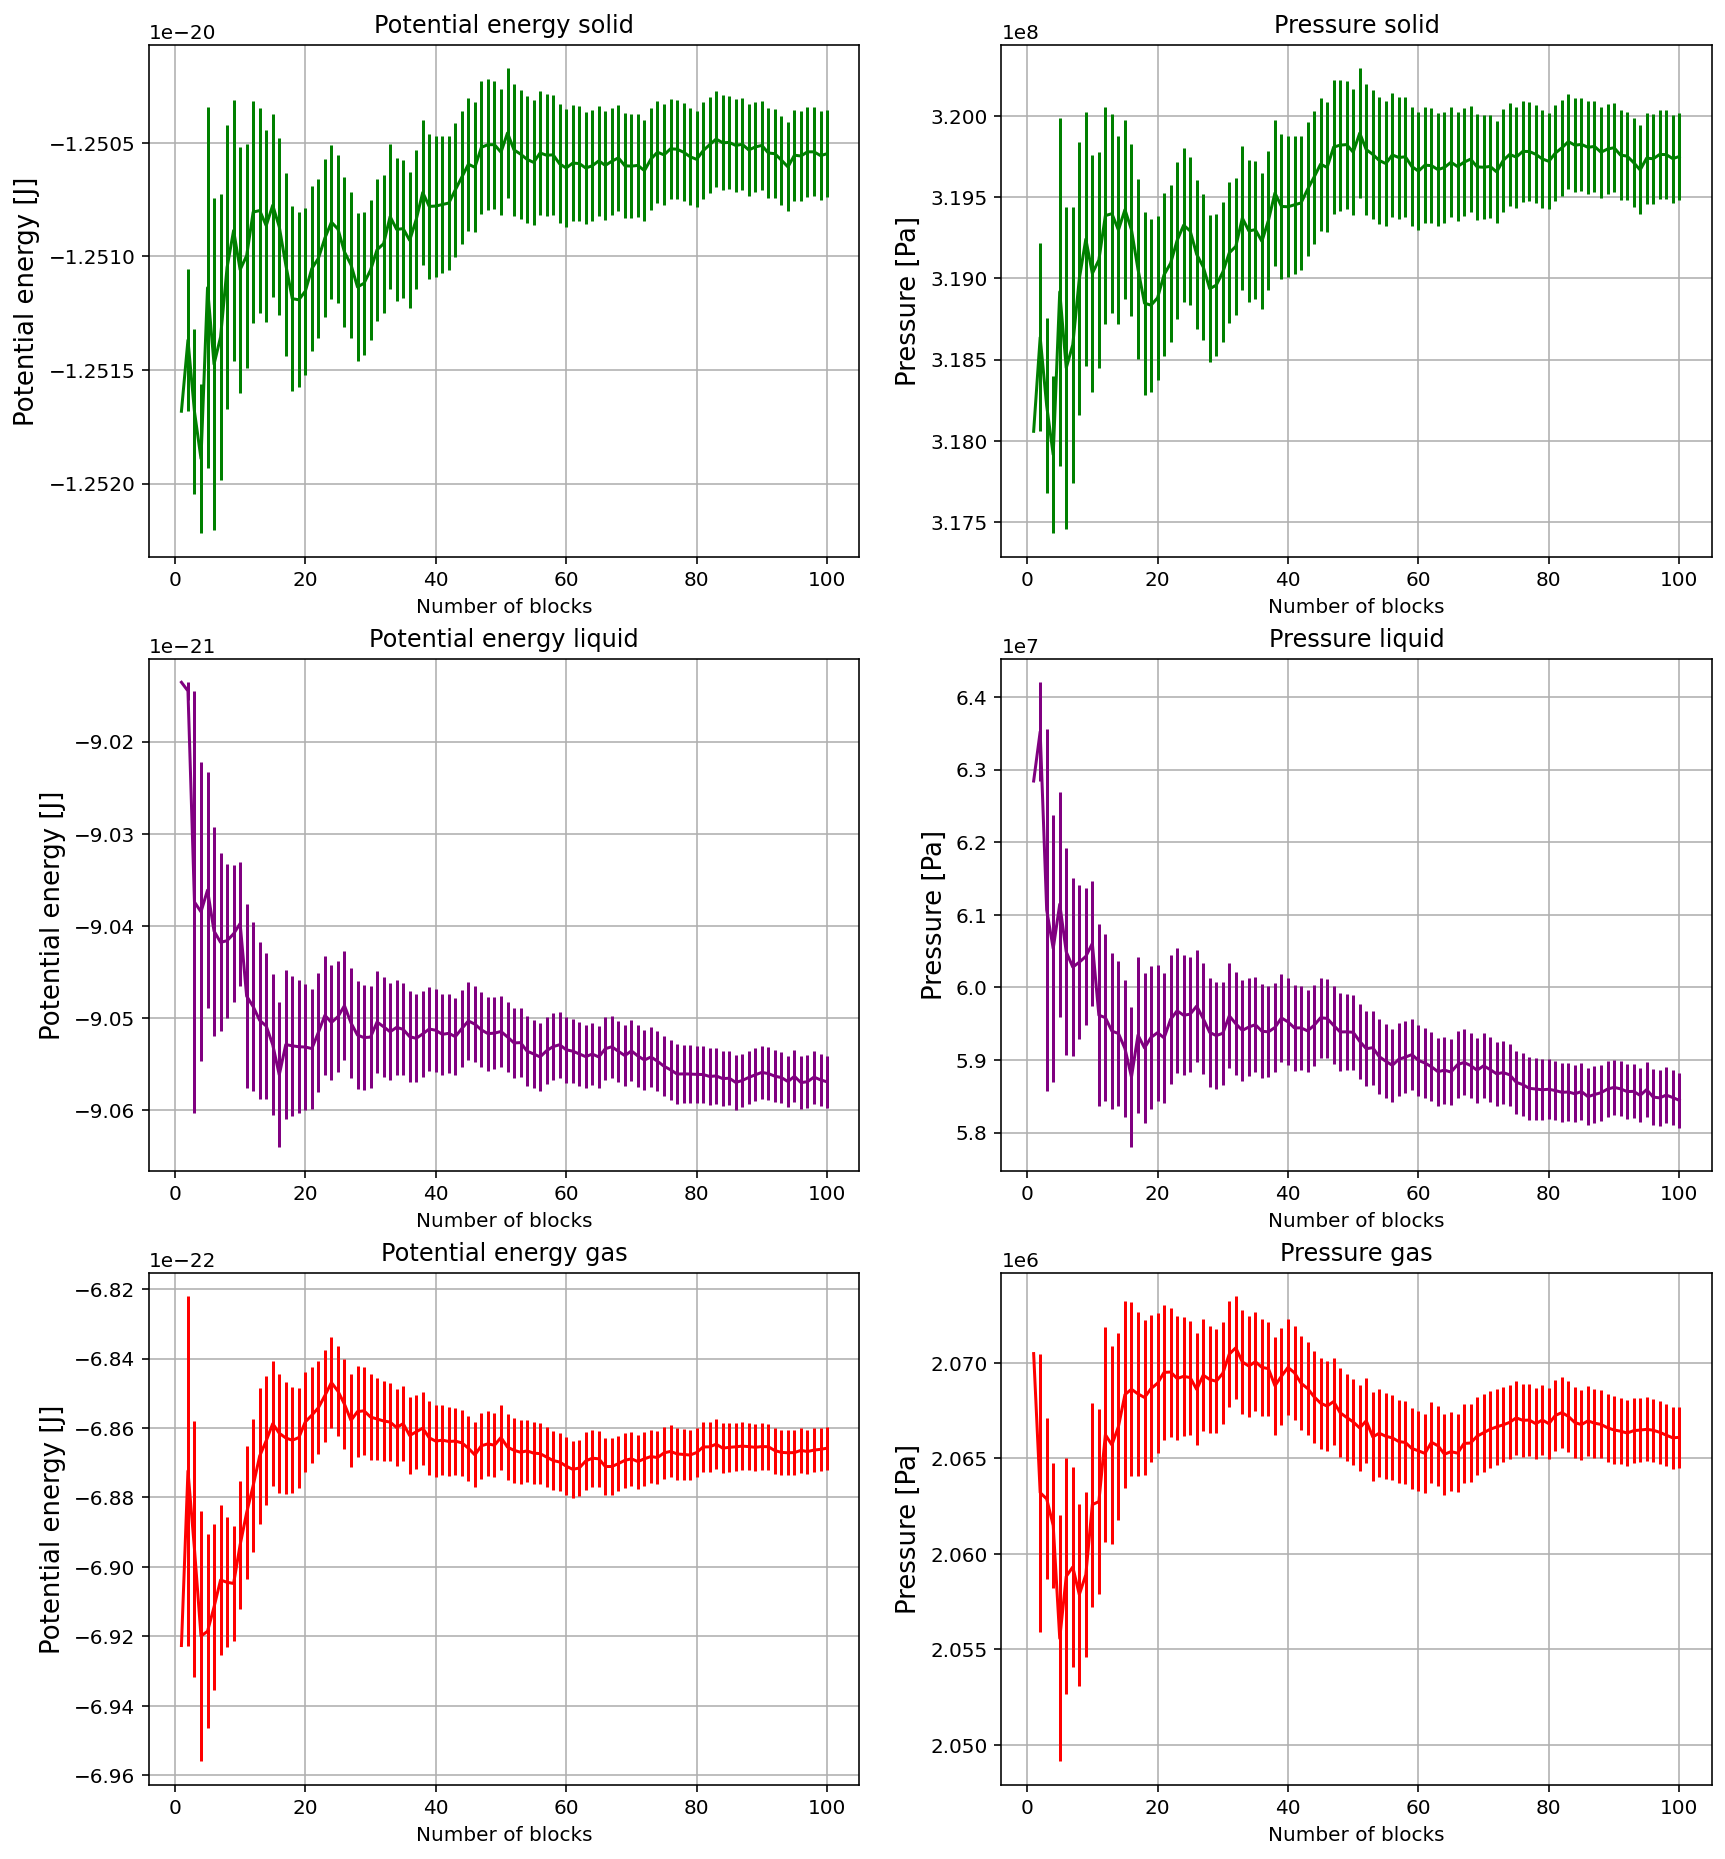

In [7]:
epsilon_kB = 120. #kelvin
kb = 1.380649*(10.**(-23))
epsilon = epsilon_kB*kb

sigma = 0.34*(10**(-9))
fatt_pres = epsilon/(sigma**3)


blk, ene_solid, err_ene_solid=np.loadtxt('./MonteCarlo_NVT/solid_phase/output.epot.0', unpack=True, usecols=(0,2,3))
blk, pres_solid, err_pres_solid=np.loadtxt('./MonteCarlo_NVT/solid_phase/output.pres.0', unpack=True, usecols=(0,2,3))
blk, ene_liquid, err_ene_liquid=np.loadtxt('./MonteCarlo_NVT/liquid_phase/output.epot.0', unpack=True, usecols=(0,2,3))
blk, pres_liquid, err_pres_liquid=np.loadtxt('./MonteCarlo_NVT/liquid_phase/output.pres.0', unpack=True, usecols=(0,2,3))
blk, ene_gas, err_ene_gas=np.loadtxt('./MonteCarlo_NVT/gas_phase/output.epot.0', unpack=True, usecols=(0,2,3))
blk, pres_gas, err_pres_gas=np.loadtxt('./MonteCarlo_NVT/gas_phase/output.pres.0', unpack=True, usecols=(0,2,3))

fig, axs = plt.subplots(3, 2, figsize=(14,16))

axs[0][0].errorbar(blk, ene_solid*epsilon, yerr=err_ene_solid*epsilon, color='green')
axs[0][0].set_title("Potential energy solid")
axs[0][0].set_ylabel("Potential energy [J]", fontsize=13)

axs[0][1].errorbar(blk, pres_solid*fatt_pres, yerr=err_pres_solid*fatt_pres, color='green')
axs[0][1].set_title("Pressure solid")
axs[0][1].set_ylabel("Pressure [Pa]", fontsize=13)

axs[1][0].errorbar(blk, ene_liquid*epsilon, yerr=err_ene_liquid*epsilon, color='purple')
axs[1][0].set_title("Potential energy liquid")
axs[1][0].set_ylabel("Potential energy [J]", fontsize=13)

axs[1][1].errorbar(blk, pres_liquid*fatt_pres, yerr=err_pres_liquid*fatt_pres, color='purple')
axs[1][1].set_title("Pressure liquid")
axs[1][1].set_ylabel("Pressure [Pa]", fontsize=13)

axs[2][0].errorbar(blk, ene_gas*epsilon, yerr=err_ene_gas*epsilon, color='red')
axs[2][0].set_title("Potential energy gas")
axs[2][0].set_ylabel("Potential energy [J]", fontsize=13)

axs[2][1].errorbar(blk, pres_gas*fatt_pres, yerr=err_pres_gas*fatt_pres, color='red')
axs[2][1].set_title("Pressure gas")
axs[2][1].set_ylabel("Pressure [Pa]", fontsize=13)

for ax in axs.flat:
    ax.set_xlabel('Number of blocks')
    ax.grid(True)

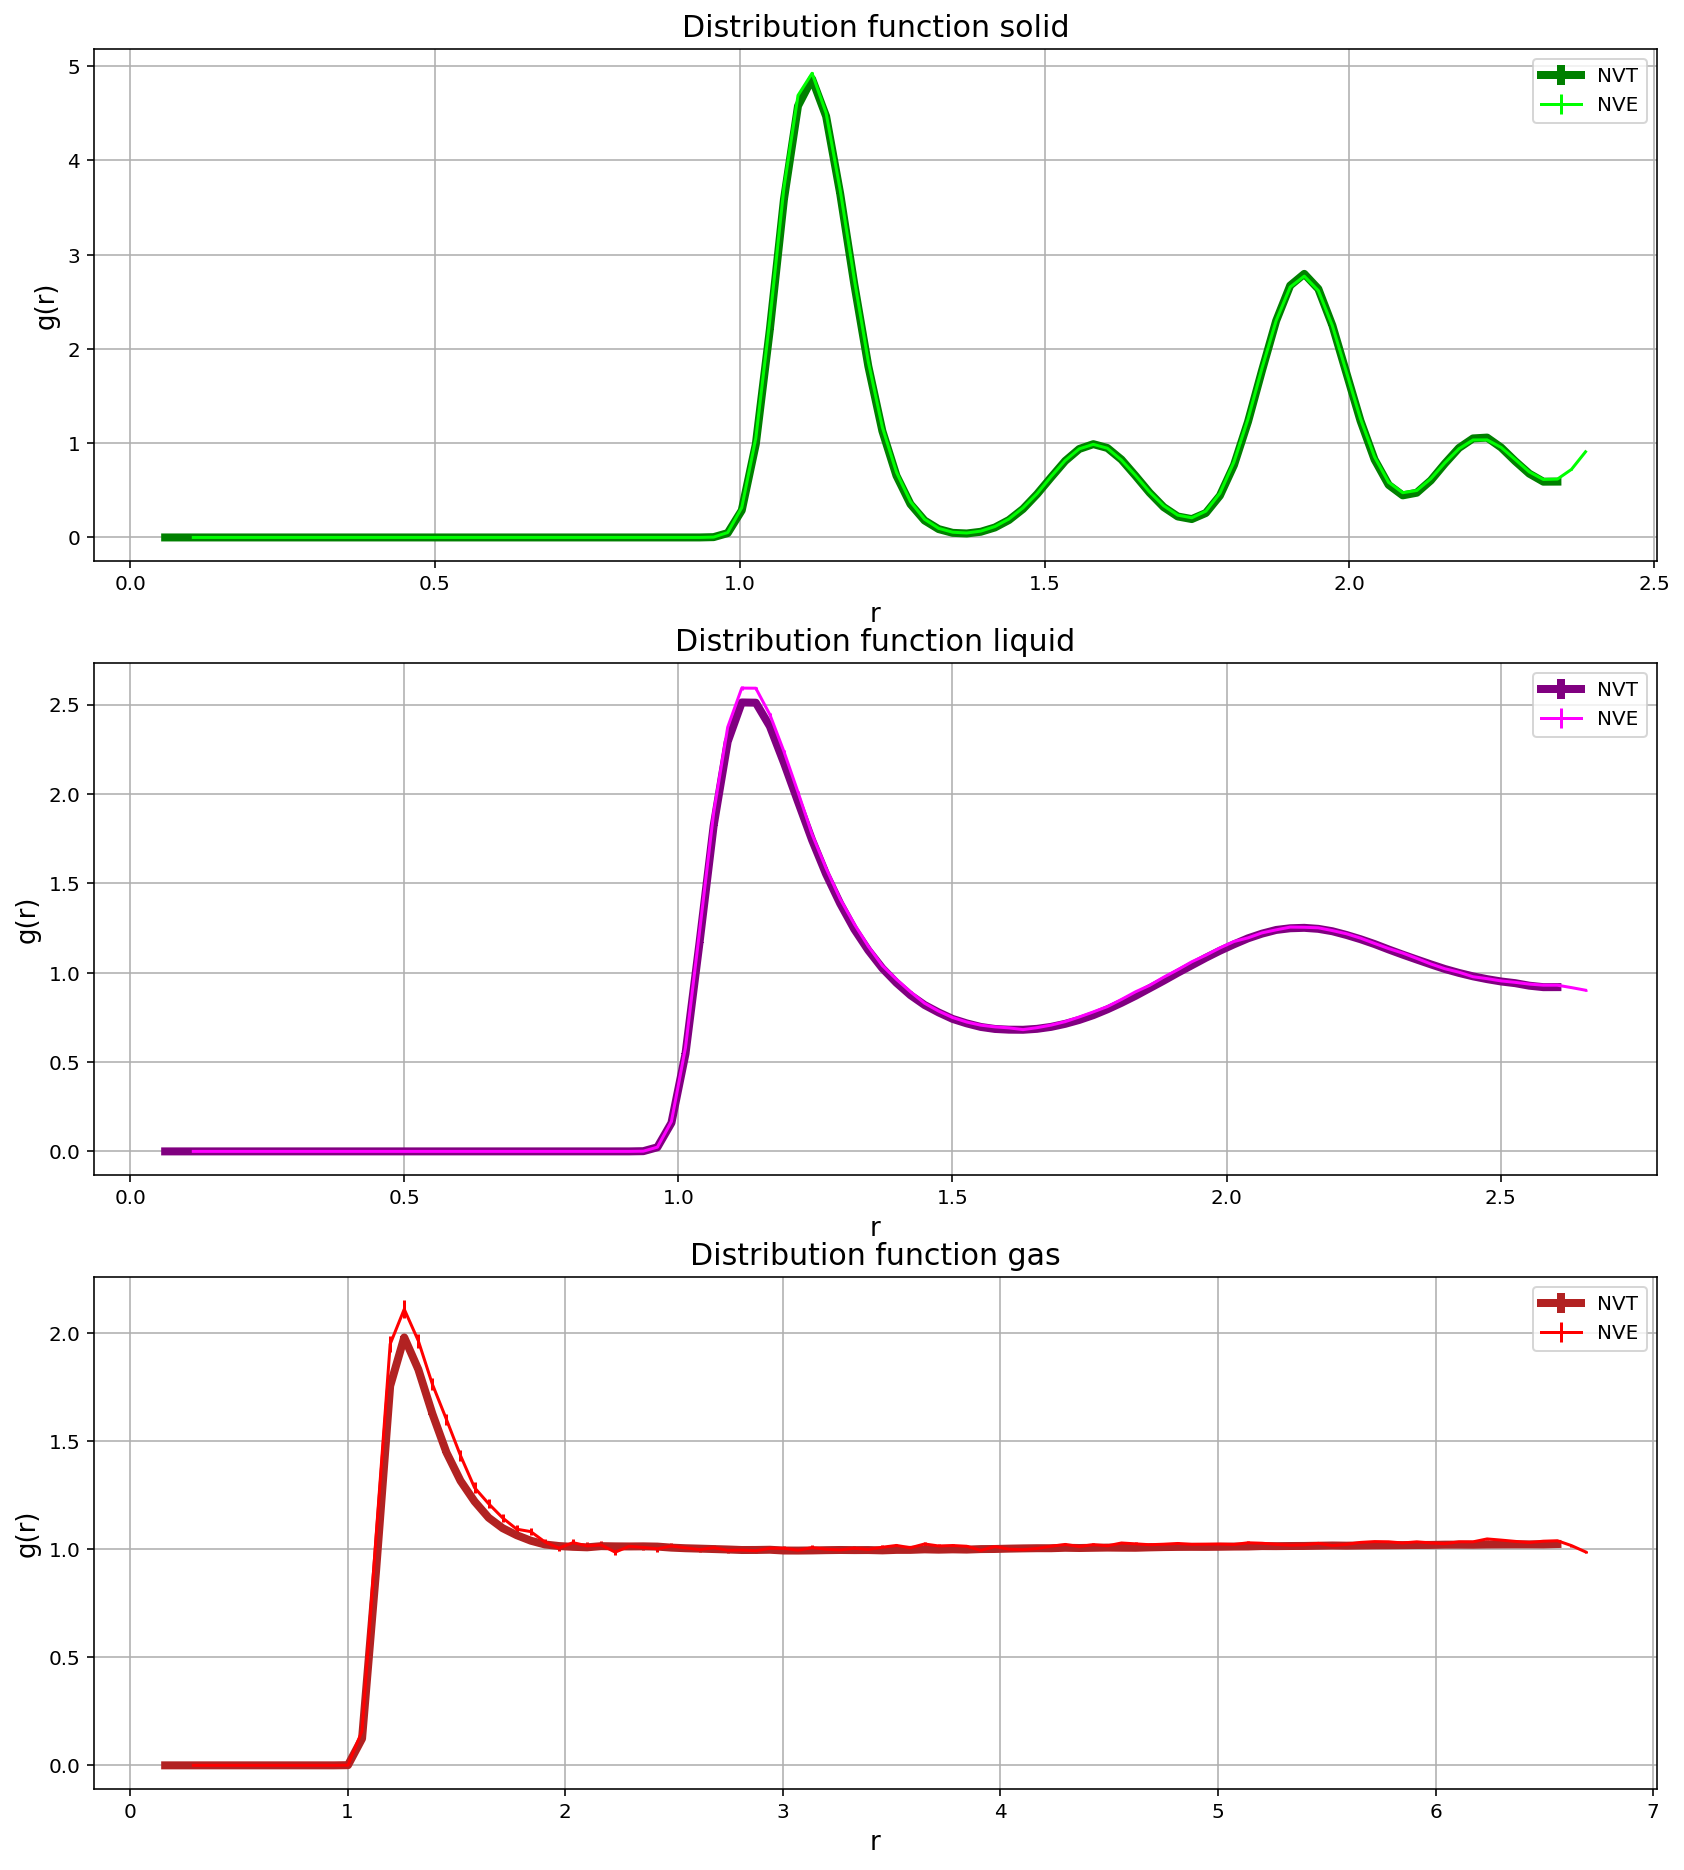

In [8]:
(r_solid, g_solid, err_solid) = np.loadtxt('./MonteCarlo_NVT/solid_phase/output.gave.0', unpack=True, usecols=(1,2,3))
(r_liquid, g_liquid, err_liquid) = np.loadtxt('./MonteCarlo_NVT/liquid_phase/output.gave.0', unpack=True, usecols=(1,2,3))
(r_gas, g_gas, err_gas) = np.loadtxt('./MonteCarlo_NVT/gas_phase/output.gave.0', unpack=True, usecols=(1,2,3))

(r_solid_4, g_solid_4, err_solid_4) = np.loadtxt('../Labo_4/04.1/MolecularDynamics_NVE/solid_phase/output.gave.0', unpack=True, usecols=(1,2,3))
(r_liquid_4, g_liquid_4, err_liquid_4) = np.loadtxt('../Labo_4/04.1/MolecularDynamics_NVE/liquid_phase/output.gave.0', unpack=True, usecols=(1,2,3))
(r_gas_4, g_gas_4, err_gas_4) = np.loadtxt('../Labo_4/04.1/MolecularDynamics_NVE/gas_phase/output.gave.0', unpack=True, usecols=(1,2,3))



fig, axs = plt.subplots(3, 1, figsize=(14,16))


# Solid g(r)
axs[0].set_title("Distribution function solid", fontsize=15)
axs[0].errorbar(r_solid, g_solid, yerr=err_solid, color='green',linewidth=4, label='NVT')
axs[0].errorbar(r_solid_4, g_solid_4, yerr=err_solid_4, color='lime', label='NVE')
axs[0].set_xlabel('r', fontsize=13)
axs[0].set_ylabel('g(r)', fontsize=13)

# Liquid g(r)
axs[1].set_title("Distribution function liquid", fontsize=15)
axs[1].errorbar(r_liquid, g_liquid, yerr=err_liquid, color='purple', label='NVT', linewidth=4)
axs[1].errorbar(r_liquid_4, g_liquid_4, yerr=err_liquid_4, color='fuchsia', label='NVE')
axs[1].set_xlabel('r', fontsize=13)
axs[1].set_ylabel('g(r)', fontsize=13)

# Gas g(r)
axs[2].set_title("Distribution function gas", fontsize=15)
axs[2].errorbar(r_gas, g_gas, yerr=err_gas, color='firebrick',label='NVT', linewidth=4)
axs[2].errorbar(r_gas_4, g_gas_4, yerr=err_gas_4, color='red', label='NVE')
axs[2].set_xlabel('r', fontsize=13)
axs[2].set_ylabel('g(r)', fontsize=13)

for ax in axs.flat:
    ax.grid()
    ax.legend()